# Data Preprocessing

## Importing the libraries

In [3]:
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

## Importing the dataset

In [4]:
dataset1 = pd.read_csv('EnjoySport.txt', header=None, sep="\t")
dataset2 = pd.read_csv('Automobile2.txt', header=None, sep="\t")

#df = pd.read_csv('Automobile.txt', header=None, sep='\n')
#df = df[0].str.split('\t', expand=True)
#df.iloc[:, :12].to_csv("Automobile2.txt",sep="\t",header=False,index=False)

In [5]:
print(dataset1, "\n")
print(dataset2)

           0     1       2      3   4
0      Rainy   Hot    High  False  25
1      Rainy   Hot    High   True  30
2   Overcast   Hot    High  False  46
3      Sunny  Mild    High  False  45
4      Sunny  Cool  Normal  False  52
5      Sunny  Cool  Normal   True  23
6   Overcast  Cool  Normal   True  43
7      Rainy  Mild    High  False  35
8      Rainy  Cool  Normal  False  38
9      Sunny  Mild  Normal  False  46
10     Rainy  Mild  Normal   True  48
11  Overcast  Mild    High   True  52
12  Overcast   Hot  Normal  False  44
13     Sunny  Mild    High   True  30 

     0            1       2      3     4   ...     7     8     9     10     11
0     3  alfa-romero     gas    std   two  ...  front  dohc  four  mpfi  13495
1     3  alfa-romero     gas    std   two  ...  front  dohc  four  mpfi  16500
2     1  alfa-romero     gas    std   two  ...  front  ohcv   six  mpfi  16500
3     2         audi     gas    std  four  ...  front   ohc  four  mpfi  13950
4     2         audi     gas    s

## Splitting the dataset into the Training set and Test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset1.iloc[:, :-1], dataset1.iloc[:, -1], test_size = 0.3, shuffle=True)

train_data = pd.concat([X_train, y_train], axis =1)
test_data = pd.concat([X_test, y_test], axis =1)

print(train_data, '\n')
print(test_data)

           0     1       2      3   4
7      Rainy  Mild    High  False  35
13     Sunny  Mild    High   True  30
8      Rainy  Cool  Normal  False  38
4      Sunny  Cool  Normal  False  52
11  Overcast  Mild    High   True  52
10     Rainy  Mild  Normal   True  48
5      Sunny  Cool  Normal   True  23
0      Rainy   Hot    High  False  25
2   Overcast   Hot    High  False  46 

           0     1       2      3   4
12  Overcast   Hot  Normal  False  44
1      Rainy   Hot    High   True  30
9      Sunny  Mild  Normal  False  46
6   Overcast  Cool  Normal   True  43
3      Sunny  Mild    High  False  45


## Functions

In [7]:
def STD(target_col):
  
    #Calculate the STD of a dataset.
    return np.std(target_col)

In [8]:
print(STD(dataset1.iloc[:,-1]))
print(STD(dataset2.iloc[:,-1]))

9.321086474291743
7958.27351709494


In [9]:
print(STD([46,43,52,44]))

3.491060010942235


In [10]:
def STDR(data, split_attribute_index, label_index = -1):
    """
    Calculate the information gain of a dataset. This function takes three parameters:
    1. data = The dataset for whose feature the IG should be calculated
    2. split_attribute_index = the index of the feature for which the information gain should be calculated
    3. label_index = label_index of the target feature.
    """    
    #Calculate the entropy of the total dataset
    total_STD = STD(data.iloc[:,label_index])
    
    ##Calculate the entropy of the dataset
    
    #Calculate the values and the corresponding counts for the split attribute 
    vals,counts= np.unique(data[split_attribute_index],return_counts=True)

    #Calculate the weighted entropy
    Weighted_STD = np.sum([(counts[i]/np.sum(counts))*STD(data.where(data[split_attribute_index]==vals[i]).dropna().iloc[:,label_index]) for i in range(len(vals))])
    
    #Calculate the information gain
    STDR = total_STD - Weighted_STD
    return STDR

In [11]:
print(STDR(dataset1, 0))
print(STDR(dataset1, 1))
print(STDR(dataset1, 2))
print(STDR(dataset1, 3))
print(STDR(dataset2, 3))

1.6621503366302335
0.4796905747633211
0.272296195489826
0.28214938055733185
182.69085178731984


In [12]:
def ID3(data, originaldata, features, min_samples, min_CV, label_index = -1, parent_node_class = None):
    """
    ID3 Algorithm: This function takes five paramters:
    1. data = the data for which the ID3 algorithm should be run --> In the first run this equals the total dataset
 
    2. originaldata = This is the original dataset needed to calculate the mode target feature value of the original dataset
    in the case the dataset delivered by the first parameter is empty

    3. features = the feature space of the dataset . This is needed for the recursive call since during the tree growing process
    we have to remove features from our dataset --> Splitting at each node

    4. label_index = the index of the target attribute

    5. parent_node_class = This is the value or class of the mode target feature value of the parent node for a specific node. This is 
    also needed for the recursive call since if the splitting leads to a situation that there are no more features left in the feature
    space, we want to return the mode target feature value of the direct parent node.
    """   
    #Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#

    #If the dataset is empty, return the mean target feature value in the original dataset
    if len(data)==0:
        return np.mean(originaldata.iloc[:,label_index])
    
    #If all target_values have the same value, return the mean value of the target feature for this dataset
    elif len(data) <= min_samples or (STD(data.iloc[:,label_index]) / np.mean(data.iloc[:,label_index]) * 100) < min_CV:
        return np.mean(data.iloc[:,label_index])
    #######################################################

    #If the feature space is empty, return the mode target feature value of the direct parent node --> Note that
    #the direct parent node is that node which has called the current run of the ID3 algorithm and hence
    #the mode target feature value is stored in the parent_node_class variable.
    
    elif len(features) ==0:
        return parent_node_class
    
    #If none of the above holds true, grow the tree!
    
    else:
        #Set the default value for this node --> The mode target feature value of the current node
        parent_node_class = np.mean(data.iloc[:,label_index])
        
        #Select the feature which best splits the dataset
        item_values = [STDR(data,feature,label_index) for feature in features] #Return the STDR values for the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
        
        #Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
        #gain in the first run
        tree = {best_feature:{}}
        
        
        #Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
        
        #Grow a branch under the root node for each possible value of the root node feature
        
        for value in np.unique(data[best_feature]):
            value = value
            #Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
            
            #Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,originaldata,features, min_samples, min_CV, label_index,parent_node_class)
            
            #Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
            
        return(tree)

In [13]:
def predict(query,tree,default):   
    
    #1.
    for key in list(query.keys()):
        if key in list(tree.keys()):
            #2.
            try:
                result = tree[key][query[key]] 
            except:
                return default
  
            #3.
            result = tree[key][query[key]]
            #4.
            if isinstance(result,dict):
                return predict(query,result, default)

            else:
                return result

In [14]:
def test(data,tree, mean_data):
    #Create new query instances by simply removing the target feature column from the original dataset and 
    #convert it to a dictionary
    queries = data.iloc[:, :-1].to_dict(orient = "records")

    #Create a empty DataFrame in whose columns the prediction of the tree are stored
    predicted = []

    #Calculate the prediction accuracy
    for i in range(len(data)):
        predicted.append(predict(queries[i],tree,mean_data)) 
    RMSE = np.sqrt(np.sum(((data.iloc[:,-1]-predicted)**2)/len(data)))
    return RMSE

# Running the Code

In [15]:
mean_data1 = np.mean(dataset1.iloc[:,-1])
mean_data2 = np.mean(dataset2.iloc[:,-1])

averageRMSE1 = []
averageRMSE2 = []

for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(dataset1.iloc[:, :-1], dataset1.iloc[:, -1], test_size = 0.3, shuffle=True)
  train_data = pd.concat([X_train, y_train], axis =1)
  test_data = pd.concat([X_test, y_test], axis =1)

  features = train_data.columns[:-1]
  tree = ID3(train_data, train_data, features, 3, 10)
  averageRMSE1.append(test(test_data,tree, mean_data1))

print("\t\t\tEnjoySport\n")
pprint(tree)
print("\nAverage root mean square error (RMSE) for EnjoySport:" , u"\u00B1 STD = %.2f" % np.mean(averageRMSE1), u"\u00B1 %.2f" % STD(averageRMSE1) ,"\n\n")

for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(dataset2.iloc[:, :-1], dataset2.iloc[:, -1], test_size = 0.3, shuffle=True)
  train_data = pd.concat([X_train, y_train], axis =1)
  test_data = pd.concat([X_test, y_test], axis =1)

  features = train_data.columns[:-1]
  tree = ID3(train_data, train_data, features, 5, 10)
  averageRMSE2.append(test(test_data,tree, mean_data2))

print("-"*100)
print("\t\t\t\tAutomobile\n")
pprint(tree)
print("\nAverage root mean square error (RMSE) for Automobile:" , u"\u00B1 STD = %.2f" % np.mean(averageRMSE2), u"\u00B1 %.2f" % STD(averageRMSE2))

			EnjoySport

{0: {'Overcast': 47.333333333333336,
     'Rainy': {1: {'Cool': 38.0, 'Hot': 27.5, 'Mild': 35.0}},
     'Sunny': 41.0}}

Average root mean square error (RMSE) for EnjoySport: ± STD = 12.22 ± 3.21 


----------------------------------------------------------------------------------------------------
				Automobile

{1: {'alfa-romero': 15498.333333333334,
     'audi': 19348.333333333332,
     'bmw': {9: {'four': 16677.5, 'six': 28967.0}},
     'dodge': {0: {-1.0: 8921.0, 1.0: 6565.4, 3.0: 12964.0}},
     'honda': {10: {'1bbl': {0: {0.0: 8565.0, 1.0: 5964.0, 2.0: 6855.0}},
                    'mpfi': 12945.0}},
     'isuzu': 8916.5,
     'jaguar': 32250.0,
     'mazda': {6: {'fwd': {0: {0.0: 9995.0,
                               1.0: {4: {'four': 7045.0, 'two': 7682.5}}}},
                   'rwd': 18280.0}},
     'mercedes-benz': 32486.4,
     'mitsubishi': {0: {1.0: 7985.666666666667, 2.0: 6029.0, 3.0: 11489.0}},
     'nissan': {10: {'2bbl': {0: {0.0: 9249.0,
           

# Plotting the result

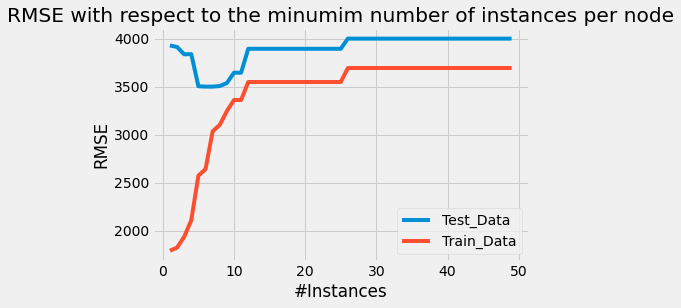

In [16]:
"""
Plot the MSE with respect to the minimum number of instances
""" 
fig = plt.figure()
ax0 = fig.add_subplot(111) 

RMSE_test = []
RMSE_train = []
for i in range(1,50):
    tree = ID3(train_data,train_data,train_data.columns[:-1],i,10)
    RMSE_test.append(test(test_data,tree,mean_data2)) 
    RMSE_train.append(test(train_data,tree,mean_data2))
   
ax0.plot(range(1,50),RMSE_test,label='Test_Data')
ax0.plot(range(1,50),RMSE_train,label='Train_Data')
ax0.legend()
ax0.set_title('RMSE with respect to the minumim number of instances per node')
ax0.set_xlabel('#Instances')
ax0.set_ylabel('RMSE')
plt.show()